# Introduction to Pytorch

### Tensors
They are specialized data structure that are very similar to arrays and matrices. They are similar to Numpy's ndarrays. Tensors can run on GPUs and other hardware accelerators.

In [ ]:
import torch
import numpy as np

In [ ]:
# initializing a tensor

# directly from data
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
print(x_data)

# from a NumPy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print(x_np)

# From another tensor
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]])
Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.7828, 0.1434],
        [0.7742, 0.5173]]) 



In [ ]:
# Attributes of a Tensor

tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

tensor = torch.ones(4, 4)
print(f"\nFirst row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


### Indexing, Slicing, Broadcasting

In [ ]:
# Indexing

t = torch.tensor([[1,2,3],[4,5,6]])

print(t[0])     # First row
print(t[1][2])  # 2nd row, 3rd col
print(t[:, 1])  # All rows, 2nd column


# Slicing

print(t[0:2, 1:3])   # rows 0-1 + cols 1-2
print(t[0:2, 1:3])


# Ellipsis(...)

t[..., 1]     # select the second row across all dimensions


# Broadcasting - automatic expansion of tensors to match shapes when operating.

t = torch.tensor([[1,2,3],[4,5,6]])
v = torch.tensor([10,20,30])    # v is broadcast (repeated across rows)

print(t + v)




tensor([1, 2, 3])
tensor(6)
tensor([2, 5])
tensor([[2, 3],
        [5, 6]])
tensor([[2, 3],
        [5, 6]])
tensor([[11, 22, 33],
        [14, 25, 36]])


### Loading a Dataset

We use the Fashion-MNIST dataset from TorchVision for this training.
- root is the path where the train/test data is stored,
- train specifies training or test dataset,
- download=True downloads the data from the internet if it’s not available at root.
If you're training with multiple processes, download the dataset once before launching distributed training. Otherwise, all processes might try downloading at the same time and break things.
- transform and target_transform specify the feature and label transformations

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.66MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 59.0MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]


### Iterating and Visualizing the Dataset

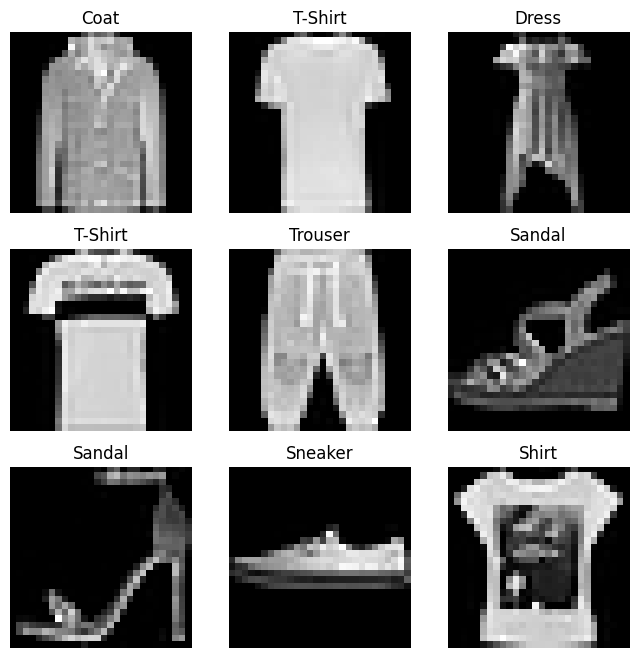

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    #This produces a tensor with 1 random index from 0 to len(training_data)-1, and converts the one element tensor to python integer
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Creating a Custom Dataset for your files

Define a class that implements three required methods:
- __init__: Runs once when the dataset is created. Loads file paths, CSV labels, and sets transforms
- __len__	Returns how many samples are in the dataset.
- __getitem__	Given an index, returns the image and its label (with transforms applied

This allows PyTorch's DataLoader to fetch images one-by-one during training

Built-in datasets (MNIST, CIFAR-10) already know how to load their data but if you have your own dataset, PyTorch doesn't know where images are, what labels they have and how to read them. So you write a custom class to teach PyTorch how.
Think of this class like a waiter in a restaurant
- __init__ = bringing the menu (dataset metadata)
- __len__ = how many items on the menu
- __getitem__ = bringing the specific order when asked


In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):

      # Read the CSV file, save the folder where images live and store optional transforms (operations on images/labels)
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
      # how many samples
        return len(self.img_labels)

    # this runs every time the DataLoader asks for a batch
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


### Preparing your data for training with DataLoaders

In Pytorch, a Dataset gives you one sample at a time and a DataLoader wraps the dataset. When we train a Neural Network, we dont feed one image at a time. Instead we:
- group data into batches (e.g., 64 images per batch)
- mix data order every epoch (shuffle) for better generalization
- uses multiple CPU workers to load data faster


In [ ]:
# Creating DataLoaders

from torch.utils.data import DataLoader

# batch_size=64: each iteration gives 64 samples
# shuffle=True: reshuffles data every epoch, which is good for training
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


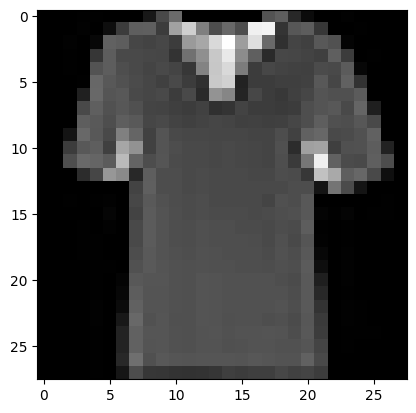

Label: 6


In [ ]:
# Iterating through the DataLoader

# iter(train_dataloader) - creates an iterator over batches
# next(...) - gets the first batch
train_features, train_labels = next(iter(train_dataloader))
print(train_features.size())  # You got 64 images, each image is 1*28*28
print(train_labels.size())    # 64 labels
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Transforms

The loaded data does not come in its processed form that could be suitable for training models. We use transforms to perform manipulations on the data to make it suitable for training. TorchVision datasets have two parameters:
- transform to modify the features
- target_transform to modify the labels
The FashionMNIST features are in PIL Image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors(tensors that represent categorical labels as binary vectors, eg. [0, 0, 1, 0] for label=2). To make these transformations, we use ToTensor and Lambda.
- ToTensor() converts a PIL image or NumPy ndarray into a FloatTensor and scales the image’s pixel intensity values in the range [0., 1.]
- Lambda Transforms creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y like y=3 and transforms it into one-hot encoded vector like [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

### Optimize Model Parameters


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.4MB/s]


## Building and Evaluating a simple multi-layer neural network for classifying handwritten digits from the MNIST dataset using PyTorch

1. Loading Data: Preprocess and load the MNIST dataset.
2. Creating the Model: Define the neural network architecture.
3. Training the Model: Train the model using the training data.
4. Testing the Model: Evaluate the model on the test data and collect performance metrics.
5. Plotting Metrics: Visualize training/testing loss, accuracy, per-class metrics, and example predictions

## Step-1: Loading Data

This is the data preprocessing pipeline for images before feeding them to a PyTorch model
- transforms.ToTensor(): Converts a PIL image or NumPy array → PyTorch tensor and scales pixel values from 0–255 → 0–1 range
- transforms.Normalize((0.1307,), (0.3081,)): This standardizes the data:(0.1307,) → mean of MNIST/Fashion-MNIST dataset (grayscale channel) and (0.3081,) → standard deviation of dataset. This makes training faster and more stable.

In [7]:
# Step 1 - Loading Data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the training and testing data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.24MB/s]


In [8]:
for x,y in train_loader:
    break

x.shape


torch.Size([64, 1, 28, 28])

### Step 2: Creating the model





In [9]:
# Define a simple multi-layer Neural Network
# Classifies MNIST/Fashion-MNIST images (28×28 pixels, 10 classes)
# Use 3 fully-connected layers and is a simple feed-forward neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10) # We have 10 different classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)     # Flatten the image from (1,28,28) → (1,784)
        x = F.relu(self.fc1(x))     # Hidden layer #1 activation
        x = F.relu(self.fc2(x))
        x = self.fc3(x)             # Raw output scores (logits)
        return F.log_softmax(x, dim=1)
        # Converts scores to log-probabilities. log_softmax is used as PyTorch training loops use Negative log-likelihood loss and NLLLoss expects log-probabilities

# Initialize the model
model = Net()

# Move the model to GPU if available, else fall back to CPU. then send that model's parameters to that device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device = }")
model.to(device)

device = device(type='cuda')


Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
!pip install --q torchsummary
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


## Step 3: Training the model

First, we set the model into training mode and then initialize the tracking variables -> train_loss keeps the running log of training loss and correct keeps count of correctly classified samples
Then we loop over mini-batches of data. Each batch is a tuple(data, target). We then move the data to device (both images and labels). We then clear old gradients from the previous step; otherwise gradients would accumulate. Then we feed the input data through the model to get predicted outputs (log probabilities here)-doing forward pass. Now we compute the loss- Negative Log Likelihood Loss, typically used when your model’s last layer is log_softmax. This compares the predicted log-probabilities (output) with the true labels (target). Then, we perform backpropagation, computing gradients for all model parameters and update the model weights. We then log every 100 batches and track loss and accuracy to accumulate total loss and correct predictions. Finally, we compute average loss and accuracy for the epoch.

In [11]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, batch in enumerate(train_loader):
        (data, target) = batch
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

### Step 4: Testing the model


This evaluates your model on the test or validation dataset. First, it puts the model in evaluation mode taht disables behaviors like Dropout and BatchNorm updates. We need to turn off gradient tracking since we’re not training — this saves memory and computation time. Then loop pver test data, compute total loss, count correct predictions, compute average loss and accuracy and print and return results.



In [12]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return test_loss, accuracy


## Step 5: Main Training and Testing Loop

Now, we will run the training and testing loops and store the results for plotting later.


In [13]:
!pip install optim

In [14]:
from torch import optim

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Store results
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

# Training and testing the model for several epochs
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append(test_loss)
    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295704
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.366097
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.289142
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.288383
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.159445
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.052894
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.093752
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.149556
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.190136
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.221663

Test set: Average loss: 0.1286, Accuracy: 9590/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.111077
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.082876
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.065801
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.129342
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.184426
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.109542
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.085372
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.054507
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.337589
T

## Step 6: Plotting Metrics

In [16]:
!pip install -q bokeh

In [17]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
output_notebook()

# Create plots for training and testing losses
p1 = figure(title="Training and Testing Losses", x_axis_label='Epoch', y_axis_label='Loss', height = 400, width = 400)
p1.line(list(range(1, num_epochs + 1)), train_losses, legend_label="Training Loss", color="red")
p1.line(list(range(1, num_epochs + 1)), test_losses, legend_label="Testing Loss", color="green")

# Create plot for training and testing accuracies
p2 = figure(title="Training and Testing Accuracy", x_axis_label='Epoch', y_axis_label='Accuracy', height = 400, width = 400)
p2.line(list(range(1, num_epochs + 1)), train_accuracies, legend_label="Train Accuracy", color="red")
p2.line(list(range(1, num_epochs + 1)), test_accuracies, legend_label="Testing Accuracy", color="green")

# Display plots in a grid
grid = gridplot([[p1, p2]])
show(grid)

## Step 7: Per-Class Metrics

We need to calculate per-class accuracy, precision and ROC curves. This is a post-training visualization and evaluation script for the PyTorch model. output_notebook() makes Bokeh render plots inline (like Matplotlib’s %matplotlib inline).

In [19]:
from sklearn.metrics import roc_curve, auc, precision_score
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.transform import dodge
import numpy as np

output_notebook()

# Calculate per-class accuracy for training and testing
train_preds = []
train_targets = []

model.eval()    # Put model in evaluation mode (no dropout, no batchnorm updates)
with torch.no_grad():   # Disable gradient computation for faster inference
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).cpu().numpy() # Get predicted class
        train_preds.extend(pred)
        train_targets.extend(target.cpu().numpy())

# After the loop, you have predicted labels for training set and all true labels for training set. Repeat the same for test set and convert them to NumPy arrays.

train_preds = np.array(train_preds)
train_targets = np.array(train_targets)

test_preds = []
test_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).cpu().numpy()
        test_preds.extend(pred)
        test_targets.extend(target.cpu().numpy())

test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

train_class_accuracy = []
test_class_accuracy = []

# Compute per-class accuracy

for i in range(10):
    train_class_accuracy.append(np.mean(train_preds[train_targets == i] == i))
    test_class_accuracy.append(np.mean(test_preds[test_targets == i] == i))

# Data for plotting to plot per-class accuracy
classes = [str(i) for i in range(10)]
train_accuracies = train_class_accuracy
test_accuracies = test_class_accuracy

# Create the bar graph for per-class accuracy
p_acc = figure(x_range=classes, title="Per-Class Accuracy", y_axis_label='Accuracy', height=400, width=800)
p_acc.vbar(x=dodge('classes', -0.25, range=p_acc.x_range), top='train_accuracies', width=0.2, source=dict(classes=classes, train_accuracies=train_accuracies), color="red", legend_label="Train Accuracy")
p_acc.vbar(x=dodge('classes', 0.25, range=p_acc.x_range), top='test_accuracies', width=0.2, source=dict(classes=classes, test_accuracies=test_accuracies), color="green", legend_label="Test Accuracy")

p_acc.legend.location = "top_left"
p_acc.legend.title = "Accuracy Type"

# Plotting per-class ROC curves
p_roc = figure(title="Per-Class ROC Curves", x_axis_label='False Positive Rate', y_axis_label='True Positive Rate', height=400, width=800)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']

roc_curves = []
for i in range(10):
    fpr, tpr, _ = roc_curve(test_targets == i, test_preds == i)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, roc_auc))
    p_roc.line(fpr, tpr, legend_label=f"Class {i} AUC = {roc_auc:.2f}", color=colors[i], line_width=2)

p_roc.legend.location = "bottom_right"
p_roc.legend.title = "Class ROC Curves"

# Display plots in a grid
grid = gridplot([[p_acc, p_roc]])
show(grid)

## Step 8: Plotting Example Predictions

We'll create plots to show examples of correct and incorrect predictions for each class.

In [20]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

# Collecting correct and incorrect examples
correct_examples = {i: [] for i in range(10)}
incorrect_examples = {i: [] for i in range(10)}

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        for i in range(data.size(0)):
            label = target[i].item()
            prediction = pred[i].item()
            if prediction == label:
                if len(correct_examples[label]) < 2:
                    correct_examples[label].append(data[i].cpu().numpy().squeeze())
            else:
                if len(incorrect_examples[label]) < 2:
                    incorrect_examples[label].append(data[i].cpu().numpy().squeeze())

# Function to plot a single example
def plot_example(data, title):
    p = figure(title=title, x_range=(0, 28), y_range=(0, 28))
    p.image([data], x=0, y=0, dw=28, dh=28, palette="Greys256")
    p.axis.visible = False
    return p

# Create grid plots for correct and incorrect examples
correct_plots = []
incorrect_plots = []

for i in range(10):
    for j in range(2):
        correct_img = correct_examples[i][j]
        incorrect_img = incorrect_examples[i][j]

        p_correct = plot_example(correct_img, f"Correct: {i}")
        p_incorrect = plot_example(incorrect_img, f"Incorrect: {i}")

        correct_plots.append(p_correct)
        incorrect_plots.append(p_incorrect)

# Display the grid plots
correct_grid = gridplot(correct_plots, ncols=10, width=100, height=100)
incorrect_grid = gridplot(incorrect_plots, ncols=10, width=100, height=100)

show(correct_grid)
show(incorrect_grid)